In [115]:
import pandas as pd
import os
import glob
from pathlib import Path

csvs = []
parent_dir = 'demand'
for csv_file in glob.glob(os.path.join(parent_dir, '*.csv')):
    csvs.append(csv_file)

files = []
li = []
for filename in sorted(csvs):
    files.append(Path(os.path.splitext(filename)[0]).stem)
    df = pd.read_csv(filename, index_col=None, header=0)
    df.drop(df.tail(1).index,inplace=True)
    li.append(df)

df = pd.concat(li, axis=0, ignore_index=True)
os.makedirs('Data', exist_ok=True)  
df.to_csv('Data/demand.csv')  
df.head()

files = list(map(int, files))
# print(*files[:5], sep='\n')
print(len(files))
print('size: ', df.size, sep='')

1096
size: 1262592


In [116]:
df = pd.read_csv('Data/demand.csv')
df = df.drop(columns='Unnamed: 0')

f_files = []
for f in files:
  for i in range(288):
    f_files.append(f)


print(len(f_files))
df['files'] = f_files

df.head(289)

315648


,Time,Day ahead forecast,Hour ahead forecast,Current demand,files
0,00:00,23437.0,22290.0,22216.0,20190101
1,00:05,22363.0,22089.0,22106.0,20190101
2,00:10,22363.0,22089.0,22130.0,20190101
3,00:15,22363.0,22089.0,22040.0,20190101
4,00:20,22363.0,21867.0,21963.0,20190101
...,...,...,...,...,...
284,23:40,22495.0,22133.0,22096.0,20190101
285,23:45,22495.0,22133.0,21961.0,20190101
286,23:50,22495.0,21813.0,21838.0,20190101
287,23:55,22495.0,21813.0,21716.0,20190101


In [117]:
import datetime
df['Time'] = df['Time'] + ':00'
df['date'] = df['files'].astype(str) + df['Time']

df['date'] = df['date'].apply(lambda x: datetime.datetime.strptime(x, '%Y%m%d%H:%M:%S') if type(x)==str else np.NaN) 

In [118]:
df = df.drop(columns=['Time', 'files'])
df.head()

,Day ahead forecast,Hour ahead forecast,Current demand,date
0,23437.0,22290.0,22216.0,2019-01-01 00:00:00
1,22363.0,22089.0,22106.0,2019-01-01 00:05:00
2,22363.0,22089.0,22130.0,2019-01-01 00:10:00
3,22363.0,22089.0,22040.0,2019-01-01 00:15:00
4,22363.0,21867.0,21963.0,2019-01-01 00:20:00


In [27]:
df = df.apply(lambda x: x.fillna(x.mean()),axis=0)
df.isna().sum()

Day ahead forecast     0
Hour ahead forecast    0
Current demand         0
date                   0
dtype: int64

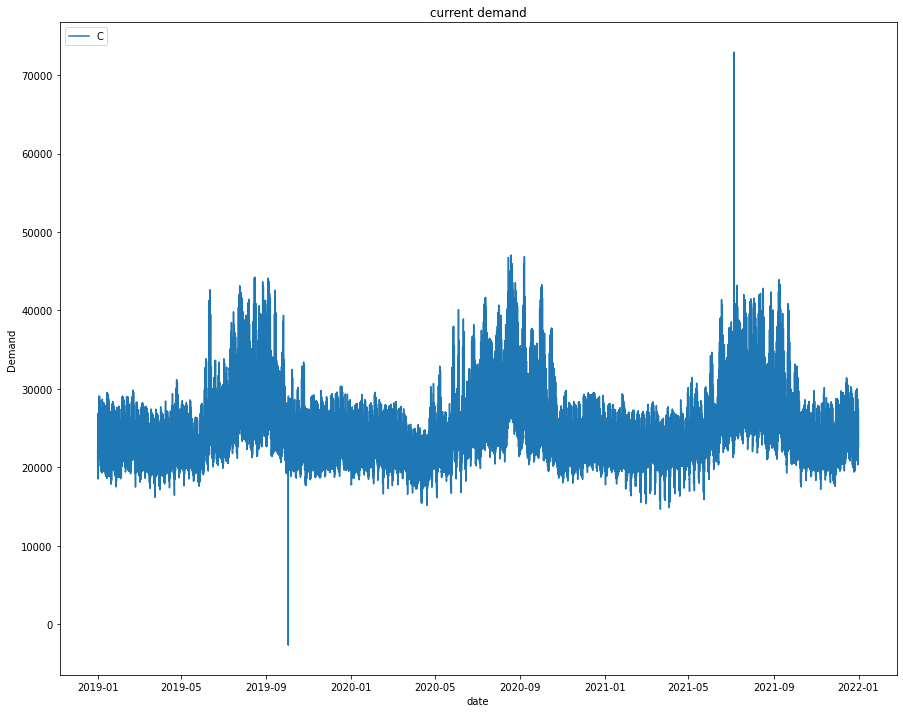

In [28]:
from matplotlib import pyplot as plt
from datetime import datetime as dt
import matplotlib.dates as md
from pandas import Timedelta as td

%matplotlib inline

plt.figure(figsize=(15,12))
plt.plot(df['date'], df['Current demand'])
plt.title('current demand')
plt.ylabel('Demand')
plt.xlabel('date')
plt.legend('Current Demand', loc='upper left')

plt.show()
print('\n')

# # plt.figure(figsize=(15,12))
# plt.plot(df['date'], df['Day ahead forecast'])
# plt.title('Day ahead forecast')
# plt.ylabel('Demand')
# plt.xlabel('date')
# plt.legend('Day ahead forecast', loc='upper left')

# plt.show()
# print('\n')

# # plt.figure(figsize=(15,12))
# plt.plot(df['date'], df['Hour ahead forecast'])
# plt.title('hour ahead forecast')
# plt.ylabel('Demand')
# plt.xlabel('date')
# plt.legend('Hour Ahead Forecast', loc='upper left')

# plt.show()

In [ ]:
#checks availability of data
import missingno as msno

msno.bar(df)          

In [ ]:
#finds correlation between data
import seaborn as sns

plt.figure(figsize=(15,12))
sns.heatmap(df.corr(), annot=True, linewidths=1, fmt='.2g', cmap='coolwarm')
plt.xticks(rotation='horizontal')

In [29]:
#makes each date information into a new collumn, year, month, etc
df['date_year'] = df['date'].dt.year
df['date_month'] = df['date'].dt.month
df['date_day'] = df['date'].dt.day            
df['date_hour'] = df['date'].dt.hour
df['date_min'] = df['date'].dt.minute
df['date_sec'] = df['date'].dt.second

df.head()

,Day ahead forecast,Hour ahead forecast,Current demand,date,date_year,date_month,date_day,date_hour,date_min,date_sec
0,23437.0,22290.0,22216.0,2019-01-01 00:00:00,2019,1,1,0,0,0
1,22363.0,22089.0,22106.0,2019-01-01 00:05:00,2019,1,1,0,5,0
2,22363.0,22089.0,22130.0,2019-01-01 00:10:00,2019,1,1,0,10,0
3,22363.0,22089.0,22040.0,2019-01-01 00:15:00,2019,1,1,0,15,0
4,22363.0,21867.0,21963.0,2019-01-01 00:20:00,2019,1,1,0,20,0


In [30]:
#resamples the data per year, week, anything we want to see
df_resampled = df.set_index('date')
# print(df_resampled.columns)

df_yearly = df_resampled['Current demand'].resample('AS').mean()   #yearly
df_yearly.columns = ['date', 'demand']
df_monthly = df_resampled['Current demand'].resample('M').mean()    #monthly
df_monthly.columns = ['date', 'demand']
df_weekly = df_resampled['Current demand'].resample('W').mean()   #weekly
df_weekly.columns = ['date', 'demand']

df_daily = df_resampled['Current demand'].resample('D').mean()   #daily
df_daily.columns = ['date', 'Current demand']

# y_df_daily = df_resampled['Day ahead forecast'].resample('D').mean()   #daily
# y_df_daily.columns = ['date', 'Day ahead forecast']

df_hourly = df_resampled['Current demand'].resample('H').mean()   #hourly
df_hourly.columns = ['date', 'demand']

# print(X_df_daily.columns, y_df_daily.columns)
df_daily

date
2019-01-01    21812.465278
2019-01-02    24134.614583
2019-01-03    24751.847222
2019-01-04    24432.812500
2019-01-05    23862.239583
                  ...     
2021-12-27    24566.732639
2021-12-28    25070.687500
2021-12-29    25498.704861
2021-12-30    24393.045139
2021-12-31    22803.527778
Freq: D, Name: Current demand, Length: 1096, dtype: float64

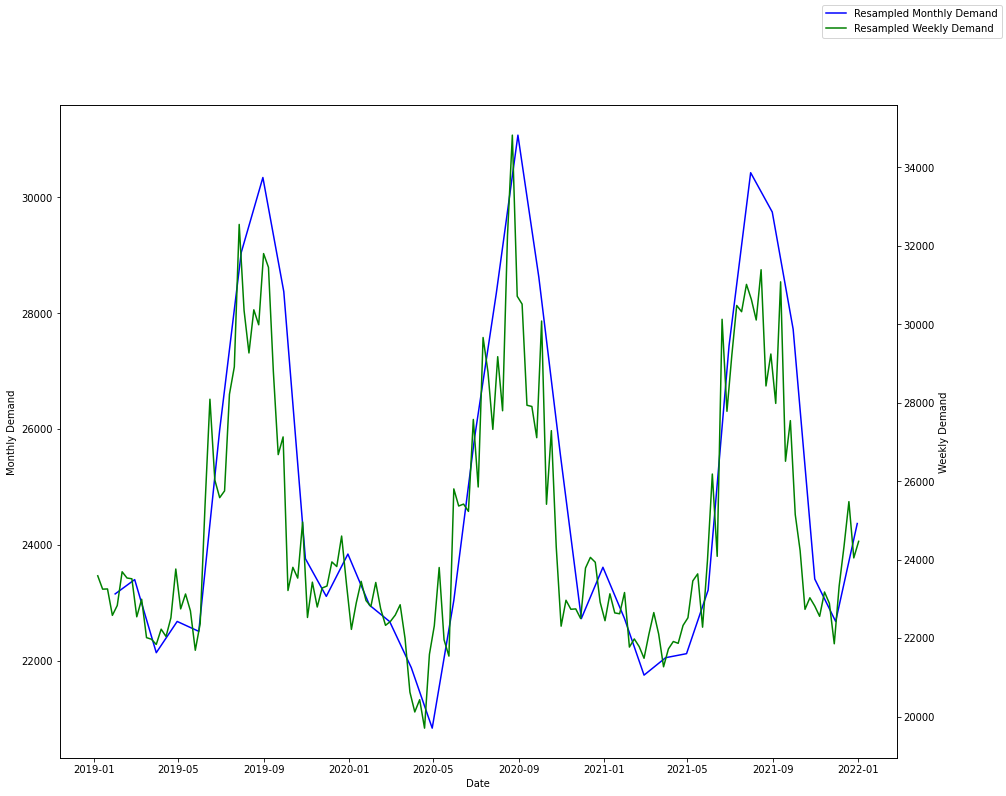

In [31]:
#resample figs
fig, ax = plt.subplots(figsize=(15,12))

ax.plot(df_monthly.index, df_monthly, color='blue')
ax.set_ylabel('Monthly Demand')
ax.set_xlabel('Date')

ax2 = ax.twinx()
ax2.plot(df_weekly.index, df_weekly, color='green')
ax2.set_ylabel('Weekly Demand')


# ax3 = ax.twinx()
# ax3.plot(df_daily.index, df_daily, color='red')

# ax4 = ax.twinx()
# ax4.plot(df_hourly.index, df_hourly, color='purple')

fig.legend(['Resampled Monthly Demand', 'Resampled Weekly Demand'], loc='upper right')
fig.show()

In [119]:
import pandas as pd
import os
import glob
from pathlib import Path

csvs_2 = []
parent_dir_2 = 'sources'
for csv_file in glob.glob(os.path.join(parent_dir_2, '*.csv')):
    csvs_2.append(csv_file)

files_2 = []
li_2 = []
for filename in sorted(csvs_2):
    files_2.append(Path(os.path.splitext(filename)[0]).stem)
    s_df = pd.read_csv(filename, index_col=None, header=0)
    # if len(s_df)!=288:
      # print(len(s_df))
    if len(s_df)>288:  
      s_df.drop(s_df.tail(1).index,inplace=True)
      # print(len(s_df))
      # print(s_df.Time)
    elif len(s_df)<288:
      # print(len(s_df))
      if len(s_df)==287:
        s_df2 = pd.DataFrame({'Time':['23:55']})
        s_df = pd.concat([s_df, s_df2], ignore_index=True, axis=0)
        s_df = s_df.fillna(s_df.mean())
        # print(s_df)
      elif len(s_df)==286:
        s_df3 = pd.DataFrame({'Time':['23:50']})
        s_df = pd.concat([s_df, s_df3], ignore_index=True, axis=0)
        s_df3 = pd.DataFrame({'Time':['23:55']})
        s_df = pd.concat([s_df, s_df3], ignore_index=True, axis=0)
        s_df = s_df.fillna(s_df.mean())
        # print(s_df)
      elif len(s_df)==285:
        s_df4 = pd.DataFrame({'Time':['23:45']})
        s_df = pd.concat([s_df, s_df4], ignore_index=True, axis=0)
        s_df4 = pd.DataFrame({'Time':['23:50']})
        s_df = pd.concat([s_df, s_df4], ignore_index=True, axis=0)
        s_df4 = pd.DataFrame({'Time':['23:55']})
        s_df = pd.concat([s_df, s_df4], ignore_index=True, axis=0)
        s_df = s_df.fillna(s_df.mean())
        # print(s_df)
      elif len(s_df)==277:
        s_df5 = pd.DataFrame({'Time':['23:05']})
        s_df = pd.concat([s_df, s_df5], ignore_index=True, axis=0)
        # minutes = 10
        # print(minutes)
        for minutes in range(10,60,5):
          s_df5 = pd.DataFrame({'Time':['23:'+str(minutes)]})
          s_df = pd.concat([s_df, s_df5], ignore_index=True, axis=0)
          # minutes+=5
        s_df = s_df.fillna(s_df.mean())
        # print(s_df)
    li_2.append(s_df)

s_df = pd.concat(li_2, axis=0, ignore_index=True)
os.makedirs('Sources_Data', exist_ok=True)  
s_df.to_csv('Sources_Data/sources.csv')  

print('files: ', len(files_2), sep='')
print('length of df: ', len(s_df), sep='')
# s_df.head(288)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is 

files: 1096
length of df: 315648


In [120]:
s_df = pd.read_csv('Sources_Data/sources.csv')
s_df = s_df.drop(columns='Unnamed: 0')

f_files_2 = []
for f in files_2:
  for i in range(288):
    f_files_2.append(f)


print(len(f_files_2))
s_df['files'] = f_files_2

s_df.head()

315648


,Time,Solar,Wind,Geothermal,Biomass,Biogas,Small hydro,Coal,Nuclear,Natural gas,Large hydro,Batteries,Imports,Other,Natural Gas,Large Hydro,files
0,00:00,0.0,2810.0,993.0,380.0,225.0,200.0,11.0,2273.0,7326.0,1924.0,6.0,6254.0,0.0,NaN,NaN,20190101
1,00:05,0.0,2862.0,993.0,381.0,226.0,201.0,11.0,2273.0,7200.0,1866.0,65.0,6266.0,0.0,NaN,NaN,20190101
2,00:10,0.0,2916.0,993.0,380.0,226.0,202.0,11.0,2272.0,7057.0,1849.0,64.0,6319.0,0.0,NaN,NaN,20190101
3,00:15,0.0,2920.0,993.0,378.0,223.0,203.0,11.0,2272.0,7007.0,1827.0,25.0,6354.0,0.0,NaN,NaN,20190101
4,00:20,0.0,2902.0,993.0,379.0,223.0,203.0,11.0,2273.0,6970.0,1840.0,32.0,6360.0,0.0,NaN,NaN,20190101


In [113]:
import datetime
print(s_df.columns)
s_df['Time'] = s_df['Time'] + ':00'
s_df['date'] = s_df['files'].astype(str) + df['Time']

s_df['date'] = s_df['date'].apply(lambda x: datetime.datetime.strptime(x, '%Y%m%d%H:%M:%S') if type(x)==str else np.NaN) 

Index(['Time', 'Solar', 'Wind', 'Geothermal', 'Biomass', 'Biogas',
       'Small hydro', 'Coal', 'Nuclear', 'Natural gas', 'Large hydro',
       'Batteries', 'Imports', 'Other', 'Natural Gas', 'Large Hydro', 'files'],
      dtype='object')


KeyError: ignored